# End-to-End Machine Learning for Magnetic Navigation Platform Calibration

As we've learned over the first few days, machine learning projects entail much more than training neural networks. In [Hands-on Machine Learning with Scikit-Learn, Keras, & TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/), a book I highly recommend, Aurelien Geron lays out the steps of an end-to-end machine learning project:

1. Look at the big picture
2. Get the data
3. Discover and visualize the data to gain insights
4. Prepare the data for Machine Learning algorithms
5. Select a model and train it
6. Fine-tune your model
7. Present your solution
8. Launch, monitor, and maintain your system

There is a full [github repository including code](https://github.com/ageron/handson-ml2) available on github. See [Chapter 2](https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb) for an example of an end-to-end project that predicts housing prices using census data. 

## Setup

Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import detrend
from pathlib import Path

Create paths for data

In [2]:
home_path = Path.home() 
flight_data_path = home_path.joinpath('magnav/flight_data')
preprocessed_data_path = home_path.joinpath('magnav/preprocessed_data')
notebook_path = home_path.joinpath('magnav/MagNav.jl/notebooks')
print(flight_data_path)
print(preprocessed_data_path)
print(notebook_path)

/home/gridsan/mokeeffe/magnav/flight_data
/home/gridsan/mokeeffe/magnav/preprocessed_data
/home/gridsan/mokeeffe/magnav/MagNav.jl/notebooks


## Look at the big picture

Magnetic navigation is an emerging technology which can be used for aerial navigation in case GPS is not available. Magnetic navigation uses maps of variations in the magnetic field originating from the crust of the earth. A navigation algorithm compares onboard measurements of the magnetic field with the map, which (combined with inertial measurements), produces an estimate of the aircraft position. 

But there's a catch! The magnetometers on the aircraft measure the total field, which is comprised of fields arising from the earth's core, diurnal variations, and the aircraft itself. In order to use the crustal anomaly field for navigation, the other contributions to the total field must be removed. Magnetic models and base-station measurements suffice to remove the core and diurnal fields, which leaves the platform field to remove. Unlike the other contributions, the aircraft field is difficult to isolate. 

The current approach to platform calibration, known as Tolles-Lawson, uses a  physics model of the aircraft fields combined with data taken during a specific flight pattern designed to maximize the contribution arising from the platform. Tolles-Lawson works well when the aircraft field is small compared to the earth field (core plus crustal), for example when the magnetometer is located in a stinger trailing the aircraft (Mag 1), but falls short for magnetometers located in the cabin (Mag 3, Mag 5). 

Your task is to perform platform calibration for the cabin magnetometers, getting the predicted values as close to the professionally-compensated stinger magnetometer. In addition to the uncalibrated and Tolles-Lawson calibrated scalar magnetometers, which detect the magnitude of the field, you will have measurements from vector magnetometers, which detect the three cartesian components of the field, located throughout the aircraft. Performance will be measured using root mean square error (RMSE). 

In [3]:
# TODO: Add figures 
# - magnetic map and aircraft with correct mag 1,3,5 locations
# - Tolles Lawson pattern
# - plot of TL mag 1,3,5 compared to compensated mag

## Get the data

### Flight data

In [4]:
flight_data = pd.read_csv(flight_data_path.joinpath("Flt1002-magnetometers.csv"))

In [5]:
flight_data.head()

,Unnamed: 0,tt,flux_b_t,flux_b_x,flux_b_y,flux_b_z,flux_c_t,flux_c_x,flux_c_y,flux_c_z,...,flux_d_z,mag_1_c,mag_1_dc,mag_1_igrf,mag_1_lag,mag_1_uc,mag_2_uc,mag_3_uc,mag_4_uc,mag_5_uc
0,0,45100.0,53533.107,28294.945,44045.834,11182.849,54584.776,-48636.719,-23909.552,-6496.585,...,-5872.882,53516.740,53522.679,-297.343,53519.854,53519.161,51888.734,51816.828,52644.111,53644.934
1,1,45100.1,53534.123,28489.807,43945.789,11087.419,54600.732,-48719.451,-23833.611,-6288.771,...,-5662.137,53517.734,53523.780,-296.223,53520.954,53520.123,51875.519,51836.852,52639.238,53650.004
2,2,45100.2,53535.215,28664.771,43859.696,10983.422,54615.024,-48800.914,-23747.780,-6105.427,...,-5477.210,53518.757,53524.904,-295.079,53522.078,53521.114,51858.647,51852.404,52634.938,53656.292
3,3,45100.3,53536.381,28817.314,43788.425,10875.071,54627.602,-48879.150,-23656.250,-5947.409,...,-5319.580,53519.817,53526.025,-293.939,53523.199,53522.145,51838.810,51861.915,52631.027,53662.324
4,4,45100.4,53537.604,28944.894,43732.820,10766.830,54638.511,-48952.235,-23563.447,-5815.530,...,-5189.712,53520.918,53527.123,-292.821,53524.298,53523.217,51818.311,51865.431,52627.730,53666.836


In [6]:
flight_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207578 entries, 0 to 207577
Data columns (total 23 columns):
Unnamed: 0    207578 non-null int64
tt            207578 non-null float64
flux_b_t      207578 non-null float64
flux_b_x      207578 non-null float64
flux_b_y      207578 non-null float64
flux_b_z      207578 non-null float64
flux_c_t      207578 non-null float64
flux_c_x      207578 non-null float64
flux_c_y      207578 non-null float64
flux_c_z      207578 non-null float64
flux_d_t      207578 non-null float64
flux_d_x      207578 non-null float64
flux_d_y      207578 non-null float64
flux_d_z      207578 non-null float64
mag_1_c       207578 non-null float64
mag_1_dc      207578 non-null float64
mag_1_igrf    207578 non-null float64
mag_1_lag     207578 non-null float64
mag_1_uc      207578 non-null float64
mag_2_uc      207578 non-null float64
mag_3_uc      207578 non-null float64
mag_4_uc      207578 non-null float64
mag_5_uc      207578 non-null float64
dtypes: float64(2

In [7]:
flight_data[['mag_3_uc', 'mag_1_uc', 'mag_1_dc', 'mag_1_igrf', 'mag_1_c']].describe()

,mag_3_uc,mag_1_uc,mag_1_dc,mag_1_igrf,mag_1_c
count,207578.000000,207578.000000,207578.000000,207578.000000,207578.000000
mean,53204.619721,53891.691425,53893.160219,15.822918,53891.706282
std,1086.295525,351.802792,349.280014,263.641503,351.901850
min,50570.347000,52777.789000,52786.905000,-868.652000,52778.111000
25%,52354.200000,53694.522750,53696.894000,-106.787250,53694.918500
50%,53049.811500,53961.552500,53958.650500,24.219500,53960.924000
75%,53914.141000,54093.997750,54088.810500,120.868500,54094.679750
max,56693.904000,56397.974000,56405.273000,2699.331000,56398.514000


### Preprocessed data

Import the preprocessed magnetometer data, to which we have applied Tolles-Lawson calibration, and corrections for diurnal and core field variations. 

In [8]:
mag_1_TL = pd.read_csv(preprocessed_data_path.joinpath("mag_1_c.csv"), header=None, names=["mag_1_TL"])
mag_3_TL = pd.read_csv(preprocessed_data_path.joinpath("mag_3_c.csv"), header=None, names=["mag_3_TL"])
mag_5_TL = pd.read_csv(preprocessed_data_path.joinpath("mag_5_c.csv"), header=None, names=["mag_5_TL"])

In [9]:
mags_TL = pd.concat([mag_1_TL, mag_3_TL, mag_5_TL], axis=1)

In [10]:
mags_TL.head()

,mag_1_TL,mag_3_TL,mag_5_TL
0,53516.758323,52784.083720,53767.486779
1,53517.748354,52788.541841,53771.847563
2,53518.768538,52790.888630,53777.615817
3,53519.827455,52788.699894,53783.080575
4,53520.925281,52782.335324,53787.009219


In [11]:
mags_TL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207578 entries, 0 to 207577
Data columns (total 3 columns):
mag_1_TL    207578 non-null float64
mag_3_TL    207578 non-null float64
mag_5_TL    207578 non-null float64
dtypes: float64(3)
memory usage: 4.8 MB


### Combine original and processed data

In [12]:
df = pd.concat([flight_data, mags_TL], axis=1)

The original dataset has 207578 time steps sampled at 10 Hz for almost six hours of flight. This project will use the subset for calibration 1, with about 12300 steps or 20 minutes, and keep only a subset of the fields. 

In [13]:
df = df.truncate(before=12701, after=25001, copy=False)
df = df[['flux_b_t',
 'flux_b_x',
 'flux_b_y',
 'flux_b_z',
 'flux_c_t',
 'flux_c_x',
 'flux_c_y',
 'flux_c_z',
 'flux_d_t',
 'flux_d_x',
 'flux_d_y',
 'flux_d_z',
 'mag_1_c',
 'mag_3_uc',
 'mag_3_TL']]
df = df.reset_index(drop=True)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12301 entries, 0 to 12300
Data columns (total 15 columns):
flux_b_t    12301 non-null float64
flux_b_x    12301 non-null float64
flux_b_y    12301 non-null float64
flux_b_z    12301 non-null float64
flux_c_t    12301 non-null float64
flux_c_x    12301 non-null float64
flux_c_y    12301 non-null float64
flux_c_z    12301 non-null float64
flux_d_t    12301 non-null float64
flux_d_x    12301 non-null float64
flux_d_y    12301 non-null float64
flux_d_z    12301 non-null float64
mag_1_c     12301 non-null float64
mag_3_uc    12301 non-null float64
mag_3_TL    12301 non-null float64
dtypes: float64(15)
memory usage: 1.4 MB


### Create a test set

For time series data, the training and test sets should be in sequential order, so do not shuffle when splitting the data. After splitting, the choice of shuffling within each set will depend on the model being trained. Regression algorithms including linear regression and feedforward neural network will work with and may benefit from shuffling, whereas a recurrent neural network relies on sequential ordering in the data. 

In [15]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, shuffle=False)

In [16]:
print("Index ranges for train and test sets:")
print(train_set.index[0], train_set.index[-1])
print(test_set.index[0], test_set.index[-1])

Index ranges for train and test sets:
0 9839
9840 12300


### Create a Test Set

## Discover and visualize the data to gain insights

Note: all field values are in units of nanoTesla and time series plots are in terms of time step (or, equivalently, index). 

Summary statistics

In [17]:
df.describe()

,flux_b_t,flux_b_x,flux_b_y,flux_b_z,flux_c_t,flux_c_x,flux_c_y,flux_c_z,flux_d_t,flux_d_x,flux_d_y,flux_d_z,mag_1_c,mag_3_uc,mag_3_TL
count,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000,12301.000000
mean,53800.809041,31557.296362,38097.549991,-7414.092561,55387.297700,-51389.909870,-5375.625617,417.848866,54404.831495,-50457.641403,-3594.205462,-1380.204657,53970.123053,53148.066768,53318.525495
std,90.354385,11681.118783,9615.954960,12781.410359,1081.763389,2666.681772,13127.035530,14815.347160,678.496783,2692.444428,13137.713851,14822.254081,39.103743,1090.792674,69.754078
min,53627.319000,-1283.854000,8300.042000,-31327.101000,52724.850000,-55598.393000,-27446.967000,-33265.666000,53066.471000,-54640.005000,-25673.036000,-35399.955000,53886.995000,51411.995000,53183.104197
25%,53716.704000,22858.739000,31271.093000,-18119.184000,54457.760000,-53168.291000,-20711.543000,-12381.404000,53874.606000,-52225.343000,-19088.569000,-14137.435000,53944.641000,52335.442000,53260.031242
50%,53824.752000,34249.977000,39217.772000,-8499.135000,55618.853000,-51886.710000,-4495.256000,1527.356000,54224.976000,-51050.309000,-2628.834000,-156.926000,53960.870000,52905.016000,53318.689068
75%,53866.545000,38264.577000,47144.977000,7740.285000,55985.744000,-50525.176000,5816.836000,8627.374000,55047.401000,-49656.352000,7557.834000,6676.917000,53997.958000,53668.371000,53373.515202
max,53967.087000,51591.498000,53505.539000,14450.525000,57573.934000,-40834.764000,19405.059000,33977.108000,56173.890000,-39532.771000,21498.281000,31878.945000,54066.039000,56314.816000,53452.812761


Scatter matrix

In [18]:
# Comment or uncomment to view scatter matrix
# It takes a few seconds to run, so commenting it out speeds up development elsewhere
# pd.plotting.scatter_matrix(df, alpha=0.1, figsize=(15, 15), diagonal="kde");

The scatter plot shows estimates of the covariance matrix, with the density distribution along the diagonal (histogram is the other option). This looks like a fascinating topic for further study.  

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc7881cda58>,
      dtype=object)

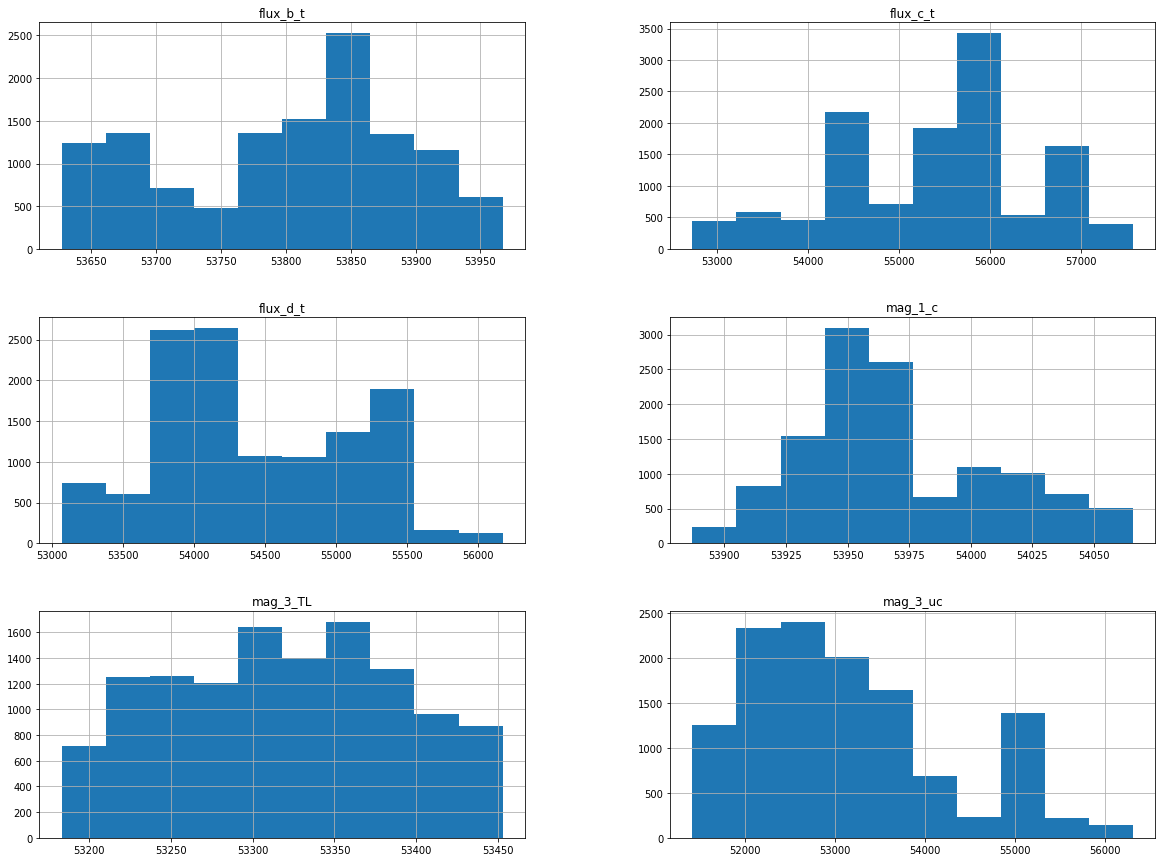

In [19]:
df[['mag_1_c', 'mag_3_uc', 'mag_3_TL', 'flux_b_t', 'flux_c_t', 'flux_d_t']].hist(figsize=(20, 15))

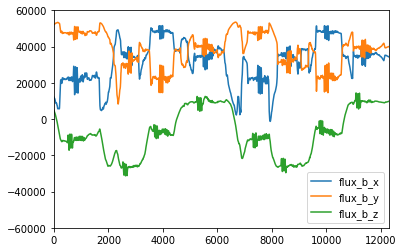

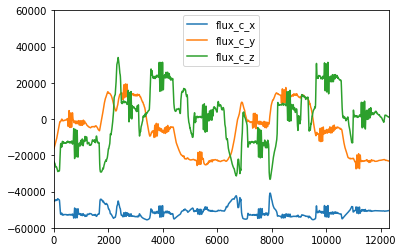

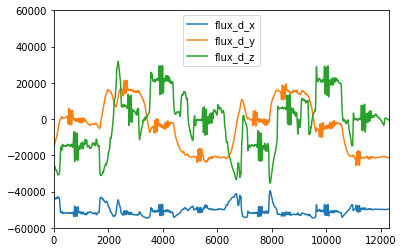

In [20]:
ylim = [-6e4, 6e4]
df[['flux_b_x', 'flux_b_y', 'flux_b_z']].plot(ylim=ylim)
df[['flux_c_x', 'flux_c_y', 'flux_c_z']].plot(ylim=ylim)
df[['flux_d_x', 'flux_d_y', 'flux_d_z']].plot(ylim=ylim)

**Observation** 

Each vector magnetometer `flux_[b, c, d]*` has four channels: `_x`, `_y`, `_z`, components and the magnitude or total field `t`. The total field is between 52000 nT and 58000 nT, whereas the components vary between -58000 nT and +58000 nT. This suggests directional information is a key component of the vector magnetometers, so feature scaling should take this into account. 

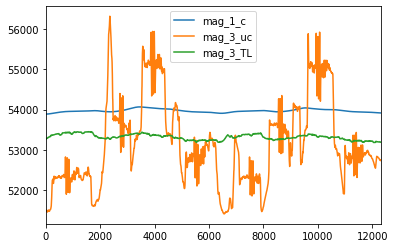

In [21]:
df[['mag_1_c', 'mag_3_uc', 'mag_3_TL']].plot()

**Observation** 

The scalar magnetometers range between 51000 nT and 57000 nT, a similar range as the total field measurements of the magnetometers. (The scalar magnetometers have values in a similar range as the total field of the vector magnetometers, but because each magnetometer is in a different location and the fluxgate (vector) magnetometers are less sensitive and stable than the scalar magnetometers, the deviations are not surprising.) 

**Note**

Magnetic navigation relies on field fluctuations in the frequency band between 1 milliHertz and 1 Hertz, so different DC offsets of the compensated magnetometers do not matter. Compare the plot of the scalar magnetometer values (above) with the mean-subtracted values (below). 

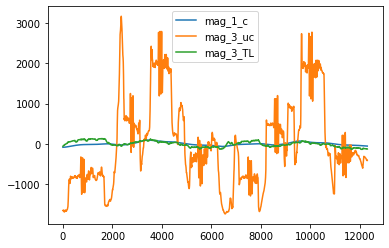

In [22]:
for cat in ['mag_1_c', 'mag_3_uc', 'mag_3_TL']:
    plt.plot(df[cat] - df[cat].mean(), label=cat)
plt.legend()

In [23]:
from sklearn.metrics import mean_squared_error

def rmse(y_true, y_pred, subtract_mean=True):
    if subtract_mean:
        return np.sqrt(mean_squared_error(y_true - y_true.mean(), 
                                          y_pred - y_pred.mean()))
    else:
        return np.sqrt(mean_squared_error(y_true, y_pred))


Because a DC offset is not important, the performance metric will be the RMSE between mean-subtracted truth and predicted values. Using the `rmse(y_true, y_pred)` function to evaluate. For comparison, the uncompensated and Tolles-Lawson compensated baseline errors are

In [24]:
mag_3_uc_rmse = rmse(df['mag_1_c'], df['mag_3_uc'])
mag_3_uc_rmse

1067.7409567202417

In [25]:
mag_3_TL_rmse = rmse(df['mag_1_c'], 
                               df['mag_3_TL'])
mag_3_TL_rmse

61.10702079917575

## Prepare the data for Machine Learning algorithms

Two of the most popular strategies for hyperparameter tuning are hold-out validation and k-fold cross-validation. This [KDnuggets post](https://www.kdnuggets.com/2017/08/dataiku-predictive-model-holdout-cross-validation.html) has a good discussion of the methods and their tradeoffs. We will use hold-out validation due to its simplicity, and to avoid data leakage by looking ahead when working with time series. It is also frequently used when training neural networks due to lower computation time.  

In [26]:
train_set, valid_set = train_test_split(train_set, test_size=0.25, shuffle=False)

Separate predictors and labels

In [27]:
train_data = train_set.drop("mag_1_c", axis=1)
train_labels = train_set["mag_1_c"].copy()
valid_data = valid_set.drop("mag_1_c", axis=1)
valid_labels = valid_set["mag_1_c"].copy()
test_data = test_set.drop("mag_1_c", axis=1)
test_labels = test_set["mag_1_c"].copy()

### Feature Scaling

Most machine learning algorithms perform better when the features are scaled to values close to one. The two most common ways are min-max scaling and standardization. Because the directional information in the vector magnetometers will likely get lost with this type of scaling, here is a custom transformer that converts the vector measurements to direction cosines. 

In [28]:
type(df)

pandas.core.frame.DataFrame

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

col_names = ['flux_b_t', 'flux_b_x', 'flux_b_y', 'flux_b_z',
             'flux_c_t', 'flux_c_x', 'flux_c_y', 'flux_c_z',
             'flux_d_t', 'flux_d_x', 'flux_d_y', 'flux_d_z']

b_t, b_x, b_y, b_z, c_t, c_x, c_y, c_z, d_t, d_x, d_y, d_z = [
    df.columns.get_loc(c) for c in col_names]

class DirectionCosineAdder(BaseEstimator, TransformerMixin):
    """Transform vector measurements to direction cosines"""
    def __init__(self, add_direction_cosines=True):
        self.add_direction_cosines = add_direction_cosines
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.values
        if self.add_direction_cosines:
            cos_b_x = X[:, b_x] / X[:, b_t]
            cos_b_y = X[:, b_y] / X[:, b_t]
            cos_b_z = X[:, b_z] / X[:, b_t]
            cos_c_x = X[:, c_x] / X[:, c_t]
            cos_c_y = X[:, c_y] / X[:, c_t]
            cos_c_z = X[:, c_z] / X[:, c_t]
            cos_d_x = X[:, d_x] / X[:, d_t]
            cos_d_y = X[:, d_y] / X[:, d_t]
            cos_d_z = X[:, d_z] / X[:, d_t]
            return np.c_[X, 
                         cos_b_x, cos_b_y, cos_b_z, 
                         cos_c_x, cos_c_y, cos_c_z,
                         cos_d_x, cos_d_y, cos_d_z]
        else:
            return np.c_[X]

attr_adder = DirectionCosineAdder()
extra_attribs = attr_adder.transform(df.values)

In [30]:
# Check that the last nine columns containing direction cosines 
# are between -1 and +1
np.all(np.abs(extra_attribs[:, -9:-1]) < 1)

True

Build a pipeline for processing

In [31]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

pipeline = Pipeline([
    ('dir_cos_adder', DirectionCosineAdder()),
    ('min_max_scaler', MinMaxScaler()) # default feature_range=(0, 1)
])

train_prepared = pipeline.fit_transform(train_data)

Try the preprocessing pipeline on a few training instances, predict values, and compare to actual values

In [32]:
some_data = train_data.iloc[:5]
some_labels = train_labels.iloc[:5]
some_data_prepared = pipeline.transform(some_data)

some_data_prepared

array([[0.31752251, 0.19986977, 0.96983964, 0.82507003, 0.14801542,
        0.77705507, 0.20732425, 0.12066266, 0.05520723, 0.76065275,
        0.18956811, 0.12608654, 0.01679258, 0.28002183, 0.20046156,
        0.96909905, 0.82432694, 0.72864163, 0.19284702, 0.13065958,
        0.73979931, 0.18698888, 0.13067206],
       [0.31797232, 0.19904339, 0.97015392, 0.82393523, 0.14738223,
        0.77740323, 0.20851669, 0.12006132, 0.0550209 , 0.7610008 ,
        0.1907367 , 0.12548661, 0.01668652, 0.28707678, 0.199632  ,
        0.96940985, 0.82318942, 0.72882659, 0.19406741, 0.13002011,
        0.74015194, 0.18818407, 0.13005308],
       [0.31840946, 0.19824135, 0.97046092, 0.82279001, 0.14674649,
        0.77770986, 0.20971417, 0.11947726, 0.05477182, 0.76134145,
        0.19190719, 0.12489779, 0.01656475, 0.28698914, 0.19882689,
        0.96971346, 0.82204147, 0.72896201, 0.1952931 , 0.12939826,
        0.74048262, 0.18937997, 0.12944402],
       [0.31882759, 0.19744094, 0.97076636, 0.821

## Select a model and train it

### Linear Regression

In [33]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(train_prepared, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [34]:
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [53888.1700486  53889.00367006 53889.26651103 53889.14628772
 53888.82300697]


In [35]:
some_data = train_data.iloc[:5]
some_labels = train_labels.iloc[:5]
some_data_prepared = pipeline.transform(some_data)

some_data_prepared

array([[0.31752251, 0.19986977, 0.96983964, 0.82507003, 0.14801542,
        0.77705507, 0.20732425, 0.12066266, 0.05520723, 0.76065275,
        0.18956811, 0.12608654, 0.01679258, 0.28002183, 0.20046156,
        0.96909905, 0.82432694, 0.72864163, 0.19284702, 0.13065958,
        0.73979931, 0.18698888, 0.13067206],
       [0.31797232, 0.19904339, 0.97015392, 0.82393523, 0.14738223,
        0.77740323, 0.20851669, 0.12006132, 0.0550209 , 0.7610008 ,
        0.1907367 , 0.12548661, 0.01668652, 0.28707678, 0.199632  ,
        0.96940985, 0.82318942, 0.72882659, 0.19406741, 0.13002011,
        0.74015194, 0.18818407, 0.13005308],
       [0.31840946, 0.19824135, 0.97046092, 0.82279001, 0.14674649,
        0.77770986, 0.20971417, 0.11947726, 0.05477182, 0.76134145,
        0.19190719, 0.12489779, 0.01656475, 0.28698914, 0.19882689,
        0.96971346, 0.82204147, 0.72896201, 0.1952931 , 0.12939826,
        0.74048262, 0.18937997, 0.12944402],
       [0.31882759, 0.19744094, 0.97076636, 0.821

In [36]:
print("Labels: ", list(some_labels))

Labels:  [53886.995, 53887.015, 53887.035, 53887.056, 53887.078]


In [37]:
train_predictions = lin_reg.predict(train_prepared)
lin_rmse = rmse(train_labels, train_predictions)
print("Training Error: ", lin_rmse)

valid_data_prepared = pipeline.transform(valid_data)
valid_predictions = lin_reg.predict(valid_data_prepared)
lin_valid_rmse = rmse(valid_labels, valid_predictions)
print("Validation Error: ", lin_valid_rmse)

Training Error:  3.9224833420591514
Validation Error:  7.8167085209976195


### Decision Tree Regression

In [38]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(train_prepared, train_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [39]:
tree_train_predictions = tree_reg.predict(train_prepared)
tree_rmse = rmse(train_labels, tree_train_predictions)
print("Training Error: ", tree_rmse)

tree_valid_predictions = tree_reg.predict(valid_data_prepared)
tree_valid_rmse = rmse(valid_labels, tree_valid_predictions)
print("Validation Error: ", tree_valid_rmse)

Training Error:  5.6148596253210676e-05
Validation Error:  21.282219837554454


### Model comparison

The linear regression model has a training error 3.9 nT and validation error 7.8 nT. The decision tree has a training error less than 1e-4 nT, but a validation error of 21 nT. This suggests a decision tree can learn a more complicated function, but is likely overfitting to the training data. Cross-validation may be useful in training and evaluating models, but some care needs to be taken for time series data. 

## Fine-tune your model

Linear regression has no hyperparameters to tune, so there is no need for fine-tuning. Ridge regression adds L2 weight regularization terms to linear regression, but a quick grid search doesn't show any improvement. Given the extensive nonlinear data processing in the direction cosines, this may not be too surprising. Additional feature engineering, for example taking the derivatives of the direction cosines which are used in Tolles-Lawson, may be helpful. 

In [40]:
from sklearn.linear_model import Ridge

for alpha in np.logspace(-8, -5, 7, endpoint=True):
    ridge_reg = Ridge(alpha=alpha)
    ridge_reg.fit(train_prepared, train_labels)
    train_predictions = ridge_reg.predict(train_prepared)
    ridge_rmse = rmse(train_labels, train_predictions)
    valid_predictions = ridge_reg.predict(valid_data_prepared)
    ridge_valid_rmse = rmse(valid_labels, valid_predictions)
    print("Ridge Parameter: ", alpha)
    print("Training Error: ", ridge_rmse)
    print("Validation Error: ", ridge_valid_rmse)


Ridge Parameter:  1e-08
Training Error:  3.9224839076148585
Validation Error:  7.818367084960964
Ridge Parameter:  3.162277660168379e-08
Training Error:  3.9224889585970124
Validation Error:  7.821941316372323
Ridge Parameter:  1e-07
Training Error:  3.922538301809136
Validation Error:  7.833136646210716
Ridge Parameter:  3.162277660168379e-07
Training Error:  3.9229975683459855
Validation Error:  7.8675025494015305
Ridge Parameter:  1e-06
Training Error:  3.9267270797521596
Validation Error:  7.9668513409155475
Ridge Parameter:  3.162277660168379e-06
Training Error:  3.9488546900926513
Validation Error:  8.212479571301513
Ridge Parameter:  1e-05
Training Error:  4.0331884314984
Validation Error:  8.670760464316869


In [41]:
import pickle

lin_reg_model = pickle.dumps(lin_reg)

In [42]:
final_model = pickle.loads(lin_reg_model)

In [43]:
test_prepared = pipeline.transform(test_data)
test_predictions = final_model.predict(test_prepared)
test_rmse = rmse(test_labels, test_predictions)
print("Training Error: ", lin_rmse)
print("Validation Error: ", lin_valid_rmse)
print("Test Error: ", test_rmse)

Training Error:  3.9224833420591514
Validation Error:  7.8167085209976195
Test Error:  4.6436832280107945


## Present your solution

Document and present with clear visualizations and easy to remember statements
- What you have learned
- What worked and what did not
- What assumptions were made
- What system limitations exist

Here are some plots comparing the final model results with the input and true values

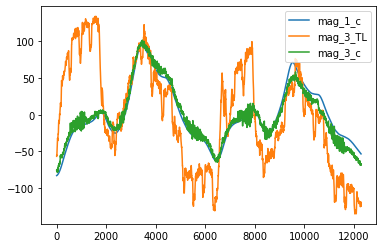

In [44]:
predictions = np.r_[train_predictions, valid_predictions, test_predictions]
for cat in ['mag_1_c', 'mag_3_TL']:
    plt.plot(df[cat] - df[cat].mean(), label=cat)
plt.plot(predictions - predictions.mean(), label='mag_3_c')
plt.legend()

Text(11000, 13, 'Test')

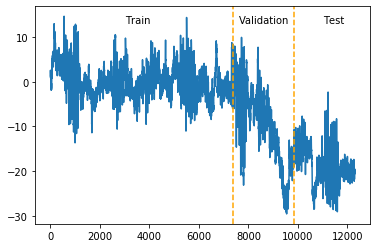

In [45]:
residuals = predictions - df['mag_1_c'].values
plt.plot(residuals, label='residuals')
plt.axvline(valid_set.index[0], ls='--', c='orange')
plt.axvline(test_set.index[0], ls='--', c='orange')
plt.text(3000, 13, 'Train')
plt.text(7600, 13, 'Validation')
plt.text(11000, 13, 'Test')

## Launch, monitor, and maintain your system

Get the solution ready for launch
- Polish the code
- Write documentation and tests
- Load onto a device on the next data collection flight!

# Project Ideas 

- Explore the data in different ways such as autocorrelation analysis (see e.g. https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html)
- Experiment with other regression algorithms such as support vector machines or neural networks (see e.g. scikit-learn User Guide for Supervised Learning (https://scikit-learn.org/stable/supervised_learning.html))
- Create a similar end-to-end machine learning project using Mag 5, which is noisier than Mag 3. (You'll need to export the Tolles-Lawson compensated values, so let me know if you need help with this)
- Instead of using a validation set, use cross-validation which trains models on different subsets of the data to estimate performance
- Try different ensemble learning techniques (see e.g. Ch 7 of Hands-on Machine Learning and [corresponding notebook](https://github.com/ageron/handson-ml2/blob/master/07_ensemble_learning_and_random_forests.ipynb))
- Experiment with neural networks using your deep learning library of choice